# Introduction

## Time evolution

#### Describing how any quantum system evolves in time is determined by an initial state $\ket{\psi_0}$ and a Hamiltonian, $2^n \times 2^n$ Hermitean matrix. The state at a later time is calculated using the time-dependent Schrödinger equation:
#### $i \hbar \frac{\partial\ket{\psi(t)}}{\partial t} = H $$\ket{\psi(t)}$
#### This can be solved on a general form such that the state after a time t is given by
#### $\ket{\psi(t)} = e^{-iHt} \ket{\psi(0)}$
#### Here $\ket{\psi(0)}$ is the initial state you start from. This is a powerful equation that can simulate time evolution of quantum systems. However, the process quite quickly breakdown as the size of the Hamiltonian and by extension the states become to large to be simulated on computers. Quantum computers have some algorithms that can help with this scaling problem, but the Hamiltonian might be extremely complicated to implement as an unitary operation. In the following we will go through Trotter decomposition that approximates the Hamiltonians used in time evolution.

## Trotter decomposition

#### The Trotter decomposition is a method to decompose an expotential function of the sum of square matrices into a product of expotential function of square matrices. The first order Trotter formula is given by:
#### $e^{A+B} = \lim_{n\rightarrow} (e^\frac{A}{n}e^\frac{B}{n})^n$
#### This method can be done to different degrees of precision, the first order Trotter approximation of two square matrices A and B is given by:
#### $e^{\delta(A+B)} = e^{\delta A} e^{\delta B} + \mathcal{O}(\delta^2)$
#### The error term is needed since the matrices A and B do not necessarily commute. This approximation is very useful in Hamiltonian simulation since Hamiltonian usaully consists of a sum of non-commuting terms. The error term can be surpressed by increasing the number of times these expotential function are multiplied together, such that:
#### $e^{\delta(A+B)} = (e^{\delta \frac{A}{n}} e^{\delta \frac{B}{n}} + \mathcal{O}((\frac{\delta}{n})^2)^n$
#### The error term can then be made arbritrarily small by simply increasing the number n, although that of course increases the depth of the circuit.

#### In a specific case of the 1D Ising model, where $H = J \sum_{i=0}^m Z_i Z_{i+1}$ and m is the number of sites in the system. For this case the time evolution operator is given by:
#### $e^{-iHt} = e^{-i J \sum_{i=0}^m (Z_i Z_{i+1}) t} \approx (\Pi_i^m e^{-iJZ_i \frac{t}{n}} e^{-iJZ_{i+1} \frac{t}{n}})^n$
#### Here we see how this approximation works by turning the complicated Ising model time evolution operator into a product of individual time evolution operators that can be implemented in series. That is the large m qubit operator can be turned into a product of n 2 qubit operators.

## Higher Order Trotterization

#### The Trotter decomposition can be done with higher precision by including more trotter terms or by including more of the error term in the approximation. The first we are going to implement is the second order Trotter approximation:
#### $e^{-i\delta(A+B)} = e^{-i \frac{\delta}{2} A}  e^{-i \delta B} e^{-i \frac{\delta}{2} A} + \mathcal{O}(\delta^3)$
#### And can likewise be approximated by including introducing Trotter steps:
#### $e^{-i\delta(A+B)} \approx (e^{-i \frac{\delta}{2n} A}  e^{-i \frac{\delta}{n} B} e^{-i \frac{\delta}{2n} A})^n$
#### *** Describe how we can do higher order Trotter with more than two terms ***

#### Higher order Trotter terms can be created recursively from this second order decomposition:
#### $\mathcal{P}_2(t) = e^{-iA t/2} e^{-iB t} e^{-iA t/2}$  
#### $\mathcal{P}_{2k}(t) = \mathcal{P}_{2k-2}(u_kt)^2 \mathcal{P}_{2k-2}((1-4u_k)t) \mathcal{P}_{2k-2}(u_kt)^2$  
#### with $u_k = 1 / (4 - 4^{1/(2k-1)})$

## Fidelity and Hilbert-Schmidt norm (2-norm)
#### Measuring how good circuit are

# Initialising packages and functions

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from functools import reduce
#from numba import njit

In [2]:
def kron_all(*gates):
    """
    Computes the Kronecker product of multiple gates.
    Flattens nested lists of gates automatically.
    
    Example:
        kron_all([[A, B], C]) -> np.kron(np.kron(A, B), C)
    """
    # Flatten the input
    flat = []
    for g in gates:
        if isinstance(g, list):
            flat.extend(g)
        else:
            flat.append(g)
    # Compute Kronecker product
    return reduce(np.kron, flat)

def gate_pow(gate, n):
    """
    Returns a list of 'gate' repeated n times.
    If you want the actual Kronecker product of the gate with itself n times,
    you can use `kron_all([gate]*n)` instead.
    """
    return [gate] * n

In [3]:
X = np.array([[0,1],[1,0]])
Y = np.array([[0,1j],[-1j,0]])
Z = np.array([[1,0],[0,-1]])
H = 1/np.sqrt(2) * np.array([[1,1],[1,-1]])
I = np.identity(2)

# Map matrices (as strings) to names
GATE_NAMES = {
    np.array2string(X): "X",
    np.array2string(Y): "Y",
    np.array2string(Z): "Z",    
    np.array2string(H): "H",
}

GATE_NAMES

{'[[0 1]\n [1 0]]': 'X',
 '[[ 0.+0.j  0.+1.j]\n [-0.-1.j  0.+0.j]]': 'Y',
 '[[ 1  0]\n [ 0 -1]]': 'Z',
 '[[ 0.70710678  0.70710678]\n [ 0.70710678 -0.70710678]]': 'H'}

In [29]:
class QuantumCircuit:
    def __init__(self, n):
        '''
        Initialises a quantum circuit in the 0 state with n qubits
        '''
        self.n = n
        self.state = np.zeros(2**n, dtype=np.complex128)
        self.state[0] = 1.0
        self.gates_history = []                           #For drawing

    def __repr__(self):
        '''
        Makes itself printable
        '''
        return f"Statevector=\n{self.state}"

    def one_gate(self, gate, n, name = None):
        '''
        Apply any gate to qubit n in circuit
        '''
        if name is None:
            gate_str = np.array2string(gate)
            name = GATE_NAMES.get(gate_str, "U")
        self.gates_history.append([name, n])
        
        I = np.identity(2)                #identity
        q = int(np.log2(len(self.state))) #number of qubits

        #tensor product between identity and gate to broadcast to circuit size
        operator = kron_all(
            gate_pow(I, n),
            gate,
            gate_pow(I, q - n -1) 
        ) 

        self.state = operator @ self.state

    def exact_time_evo(self, hamiltonian, t_max = 10, dt = 0.1):
        '''
        Calculates the exact time evolution of a Hamiltonian
        '''
        H_exact = eval(hamiltonian)
        initial_state = self.state
        
        t = np.linspace(0, t_max, int(t_max/dt))
        t = t[...,None, None]                        #reshape to be able to broadcast into H
        
        U_t = expm(-1j*H_exact*t)
        
        psi_t = U_t @ initial_state
        
        probabilities = np.abs(psi_t)**2
        return probabilities, t[:,0], psi_t, U_t

    def trotter_time_evo(self, hamiltonian, trotter_steps = 1000, t_max = 10, dt = 0.1):
        '''
        Calculates the Trotter approximation to time evolution to first order
        '''
        initial_state = self.state                     

        t = np.linspace(0, t_max, int(t_max/dt))
        t = t[...,None, None]                        #reshape to be able to broadcast into H

        U_terms = []
        # Split the Hamiltonian and create unitaries
        for term in hamiltonian.split('+'):
            U_terms.append(expm(-1j * eval(term) * t / trotter_steps))
            
        U_step = np.eye(U_terms[0].shape[1], dtype=complex)  #identity matrix to match size of U_term
        for U in U_terms:
            U_step = U_step @ U

        U_t = U_step
        for i in range(trotter_steps-1):
            U_t = U_t @ U_step
        
        psi_t = U_t @ initial_state

        probabilities = np.abs(psi_t)**2
        return probabilities, t[:,0], psi_t, U_t

    def second_trotter(self, hamiltonian, trotter_steps = 1000, t_max = 10, dt = 0.1):
        '''
        Calculates the Trotter approximation to time evolution to second order
        '''
        initial_state = self.state

        t = np.linspace(0, t_max, int(t_max/dt))
        t = t[...,None, None]                        #reshape to be able to broadcast into H
          
        U_terms = []
        H_terms = hamiltonian.split('+')
        #split the Hamiltonian and create unitaries
        for i in range(len(H_terms)):
            if i < len(H_terms) - 1: #The last term in the sum needs not to have factor of two in denominator
                U_terms.append(expm(-1j * eval(H_terms[i]) * t / (2 * trotter_steps))) #the number of terms - 1 is the exponent for trotter steps
            else: 
                U_terms.append(expm(-1j * eval(H_terms[i]) * t / (trotter_steps)))

        U_step = U_terms[-1]  #inner most matrix / last term in sum
        for i in range(1,len(U_terms)):
            U_step = U_terms[-(1+i)] @ U_step @ U_terms[-(1+i)]
            
        U_t = U_step
        for i in range(trotter_steps-1):
            U_t = U_t @ U_step

        psi_t = U_t @ initial_state

        probabilities = np.abs(psi_t)**2
        return probabilities, t[:,0], psi_t, U_t

    def measure(self, n):
        '''
        Measure qubit n in z basis
        '''
        self.gates_history.append(['M', n]) 
        I = np.identity(2)                #identity
        zero = np.array([1, 0])           #zero state
        one = np.array([0,1])             #one state
        rng = np.random.default_rng()     #setup random number generator
        q = int(np.log2(len(self.state))) #number of qubits

        #projector onto the 0 state 
        projector_0 = kron_all(
            gate_pow(I, n), 
            np.outer(zero, zero), 
            gate_pow(I, q - n - 1)
        )

        #projector onto the 1 state 
        projector_1 = kron_all(
            gate_pow(I, n),
            np.outer(one, one),
            gate_pow(I, q - n - 1)
            )

        state_0 = projector_0 @ self.state
        state_1 = projector_1 @ self.state

        p = [np.linalg.norm(state_0) ** 2, np.linalg.norm(state_1) ** 2]
        
        output = rng.choice((0,1), p = p)
        if output:
            self.state = state_1 / np.sqrt(p[1])
        else:
            self.state = state_0 / np.sqrt(p[0])
        print(f"Qubit {n} is measured to be {output}, congratulations!")
        return output

    def measure_all(self):
        '''
        Measures all qubits and give the probability of getting every outcome
        '''
        probabilities = np.abs(self.state)**2

        rng = np.random.default_rng()     #setup random number generator
        result = rng.choice(len(self.state), p = probabilities)
        
        self.state = np.zeros_like(self.state)
        self.state[result] = 1.0

        # Reverse the bitstring so qubit 0 is most significant
        bitstring = format(result, f"0{self.n}b")
        bitstring = bitstring[::-1]  # reverse
        
        return probabilities, int(bitstring, 2)

    def draw(self):
        '''
        Print a simple ASCII representation of the circuit
        '''
        # Initialize empty lines for each qubit
        lines = [["|0>"] for _ in range(self.n)]

        for name, n in self.gates_history:
            for i in range(self.n):
                if i is n:
                    lines[i].append(f"-[{name}]-")
                else:
                    lines[i].append("------")
        
        # Join and print each line
        for i in range(self.n):
            print(f"q{i} : " + "".join(lines[i]))

    def second_trotter_chat(self, hamiltonian, trotter_steps=1000, t_max=10, dt=0.1):
        '''
        Calculates the Trotter approximation to time evolution (second order) 
        for H = H1 + H2 + ... + Hn
        '''
        initial_state = self.state
    
        times = np.linspace(0, t_max, int(t_max/dt))
    
        # Split Hamiltonian into matrix terms
        H_terms = [eval(term) for term in hamiltonian.split('+')]

In [6]:
def fidelity(psi_exact, psi_trotter):
    overlap = np.sum(np.conjugate(psi_exact) * psi_trotter, axis=1, keepdims=True)
    fidelities = np.abs(overlap)**2
    return fidelities

def operator_norm(U_exact, U_trotter):
    inner_prod = U_trotter.conjugate().transpose(0,2,1) @ U_exact   #U_trotter ^dag @ U_exact
    traces = np.trace(inner_prod, axis1 = 1, axis2 = 2)             #trace the matrices
    operator_norms = 1/len(U_exact[1]) * np.abs(traces)                     #1/dim * trace is operator norm
    return operator_norms

# Simulations and plots

### Simulating the Ising Hamiltonian
#### Here we are simulating the Ising Hamiltonian with 2 sites and two hopping terms. We have set the interaction between the spins to be J = 0.5 and the hopping terms have been set to h = 1. This model needs 2 qubits to run and each additional site needs an additional qubit. The implemented Hamiltonian is:
#### $H = J (Z \otimes Z) + h (X \otimes I) + h (I \otimes X)$

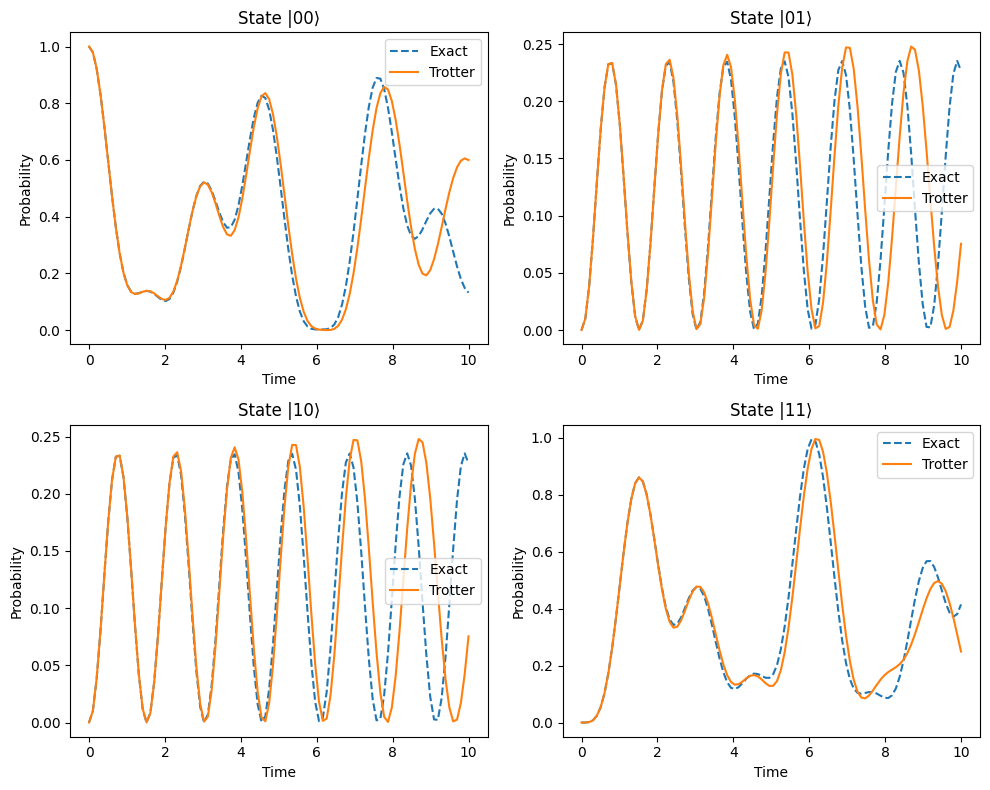

In [7]:
## Physical quantaties
J = 0.5
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

#Ising Hamiltonian for 3 sites
#hamiltonian = 'J * kron_all(Z, Z, Z) + h * kron_all(X, I, I) + h * kron_all(I, X, I) + h * kron_all(I, I, X)'

#number of qubits
n = 2

#Setting up an initial state
qc = QuantumCircuit(n)

#max time
t_max = 10
dt = 0.1

#exact time evolution
probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)

#trotter time evolution
trotter_steps = 10
probalitities_trotter, time, psi_trotter, U_trotter = qc.trotter_time_evo(hamiltonian, trotter_steps = trotter_steps, t_max = t_max, dt = dt)

#plotting
fig, axes = plt.subplots(n, n, figsize=(10, 8))  
axes = axes.flatten()  #So we can index axes[0]..axes[3]

states = [format(i, f"0{n}b") for i in range(2**n)]  #Create a bit string for given state

for i, state in enumerate(states):
    ax = axes[i]
    ax.plot(time, probabilities_exact[:, i], label="Exact", linestyle="--")
    ax.plot(time, probalitities_trotter[:, i], label="Trotter")
    ax.set_title(f"State |{state}⟩")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

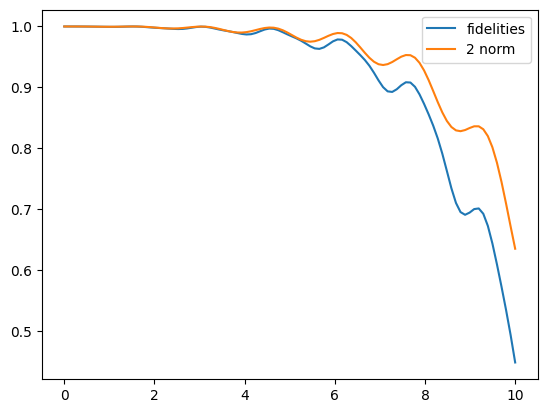

In [8]:
fidelities = fidelity(psi_exact = psi_exact, psi_trotter = psi_trotter)
operator_norms = operator_norm(U_trotter = U_trotter, U_exact = U_exact)

plt.plot(time, fidelities, label = 'fidelities')
plt.plot(time, operator_norms, label = '2 norm')
plt.legend()

### Fidelity (and 2-norm) as a function of Trotter steps
#### Here we are going to look at how the fidelity and 2-norm improves as a function of the number of trotter steps

In [19]:
#Trotter steps to try
trotter_steps = np.linspace(1, 40, 40)

#Physical quantaties
J = 0.5
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

#number of qubits
n = 2

#Setting up an initial state
qc = QuantumCircuit(n)

#max time
t_max = 10
dt = 0.1

#exact time evolution
probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)

#trotter time evolution
fidelity_arr = []
norm_arr = []
for step in trotter_steps:
    probalitities_trotter, time, psi_trotter, U_trotter = qc.trotter_time_evo(hamiltonian, trotter_steps = int(step), t_max = t_max, dt = dt)
    fidelity_arr.append(fidelity(psi_exact = psi_exact, psi_trotter = psi_trotter)[-1])
    norm_arr.append(operator_norm(U_trotter = U_trotter, U_exact = U_exact)[-1])

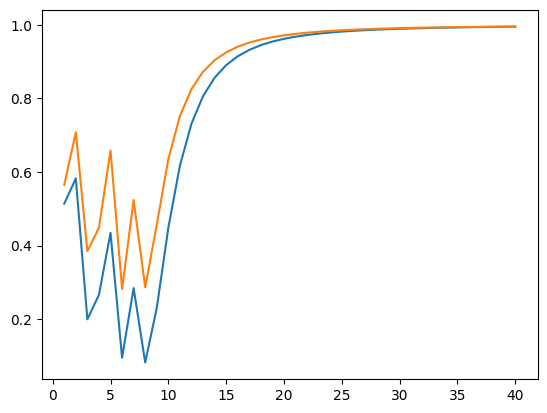

In [20]:
plt.plot(trotter_steps, fidelity_arr)
plt.plot(trotter_steps, norm_arr)

### Second Order Trotter

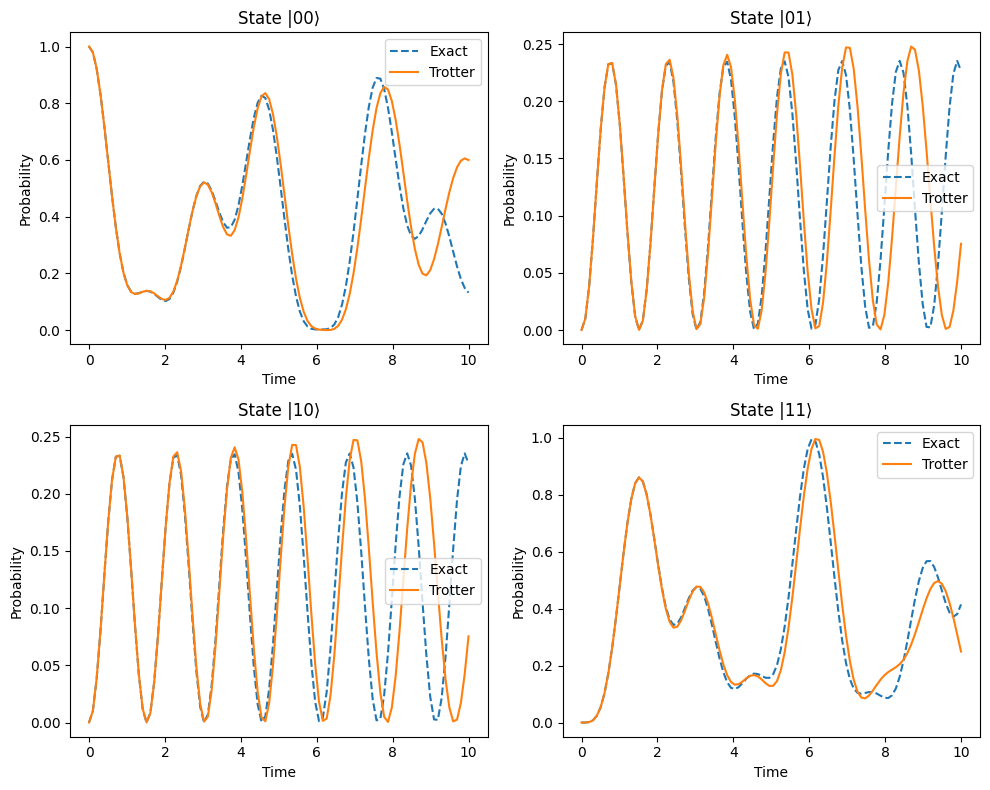

In [13]:
## Physical quantaties
J = 0.5
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

#number of qubits
n = 2

#Setting up an initial state
qc = QuantumCircuit(n)

#max time
t_max = 10
dt = 0.1

#exact time evolution
probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)

#trotter time evolution
trotter_steps = 10
probalitities_trotter2, time, psi_trotter2, U_trotter2 = qc.second_trotter(hamiltonian, trotter_steps = trotter_steps, t_max = t_max, dt = dt)

#plotting
fig, axes = plt.subplots(n, n, figsize=(10, 8))  
axes = axes.flatten()  #So we can index axes[0]..axes[3]

states = [format(i, f"0{n}b") for i in range(2**n)]  #Create a bit string for given state

for i, state in enumerate(states):
    ax = axes[i]
    ax.plot(time, probabilities_exact[:, i], label="Exact", linestyle="--")
    ax.plot(time, probalitities_trotter2[:, i], label="Trotter")
    ax.set_title(f"State |{state}⟩")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

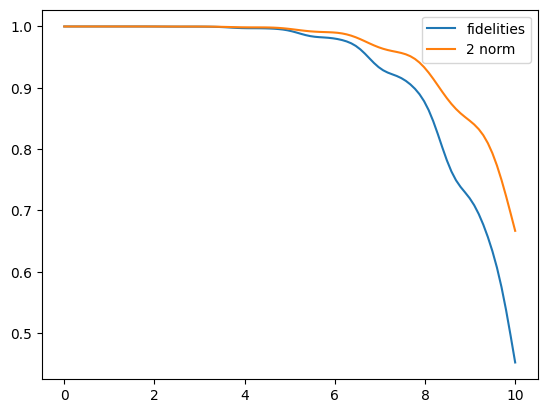

In [14]:
fidelities = fidelity(psi_exact = psi_exact, psi_trotter = psi_trotter2)
operator_norms = operator_norm(U_trotter = U_trotter2, U_exact = U_exact)

plt.plot(time, fidelities, label = 'fidelities')
plt.plot(time, operator_norms, label = '2 norm')
plt.legend()

In [17]:
#Trotter steps to try
trotter_steps = np.linspace(1, 40, 40)

#Physical quantaties
J = 0.5
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

#number of qubits
n = 2

#Setting up an initial state
qc = QuantumCircuit(n)

#max time
t_max = 10
dt = 0.1

#exact time evolution
probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)

#trotter time evolution
fidelity_arr2 = []
norm_arr2 = []
for step in trotter_steps:
    probalitities_trotter, time, psi_trotter2, U_trotter2 = qc.second_trotter(hamiltonian, trotter_steps = int(step), t_max = t_max, dt = dt)
    fidelity_arr2.append(fidelity(psi_exact = psi_exact, psi_trotter = psi_trotter2)[-1])
    norm_arr2.append(operator_norm(U_trotter = U_trotter2, U_exact = U_exact)[-1])

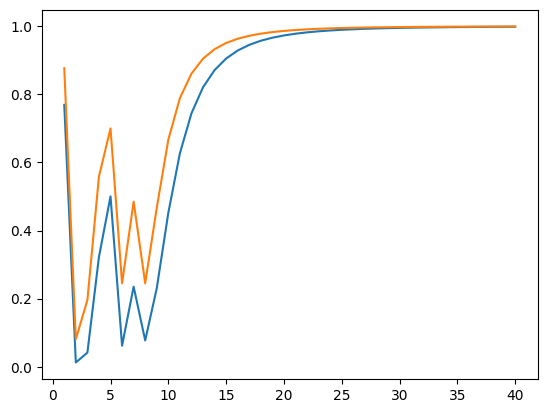

In [18]:
plt.plot(trotter_steps, fidelity_arr2)

plt.plot(trotter_steps, norm_arr2)

ValueError: x and y must have same first dimension, but have shapes (1,) and (40, 1)

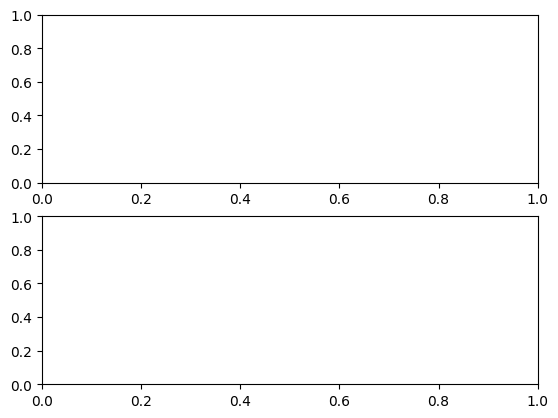

In [31]:
fig, (ax0,ax1) = plt.subplots(2,1)
ax0.plot(trotter_steps, fidelity_arr, label = 'first order')
ax0.plot(trotter_steps, fidelity_arr2, label = 'second order')

ax1.plot(trotter_steps, norm_arr, label = 'first order')
ax1.plot(trotter_steps, norm_arr2, label = 'second order')

ax0.set_ylabel('Fidelity', fontsize = 14)
ax1.set_ylabel('Norm-2', fontsize = 14)
ax1.set_xlabel('Trotter steps', fontsize = 14)

ax1.legend()

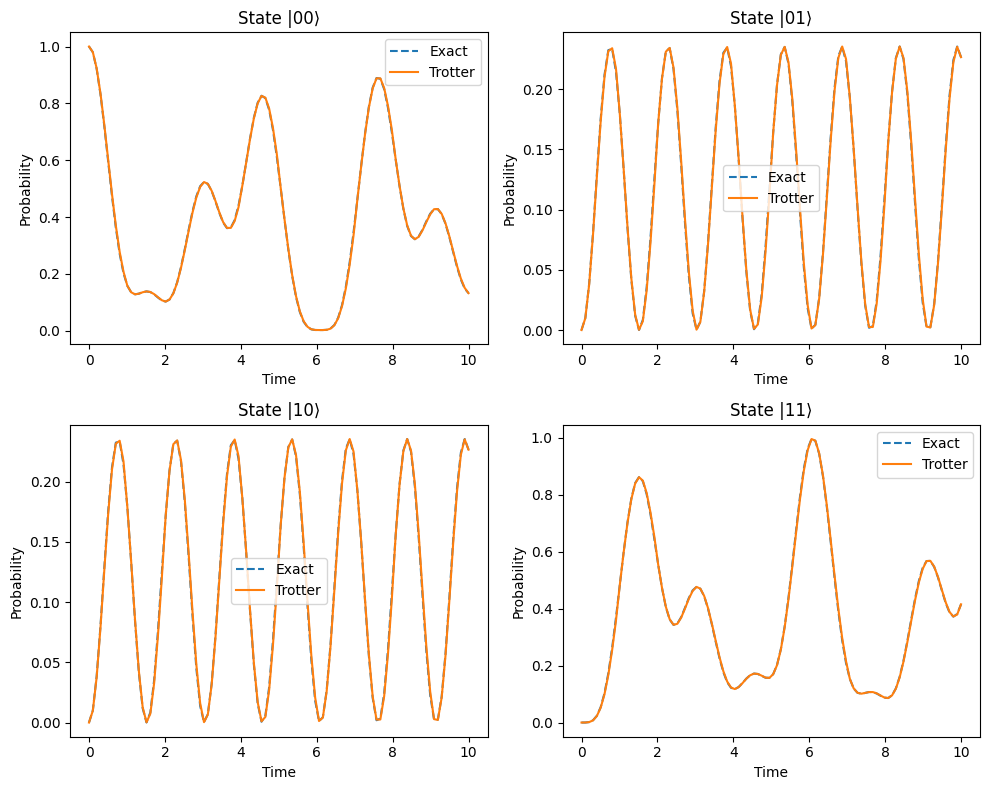

In [30]:
## Physical quantaties
J = 0.5
h = 1

#Ising Hamiltonian for 2 sites
hamiltonian = 'J * np.kron(Z, Z) + h * np.kron(X, I) + h * np.kron(I, X)'

#number of qubits
n = 2

#Setting up an initial state
qc = QuantumCircuit(n)

#max time
t_max = 10
dt = 0.1

#exact time evolution
probabilities_exact, time, psi_exact, U_exact = qc.exact_time_evo(hamiltonian, t_max = t_max, dt = dt)

#trotter time evolution
trotter_steps = 10
probalitities_trotter2, time, psi_trotter2, U_trotter2 = qc.second_trotter_chat(hamiltonian, trotter_steps = trotter_steps, t_max = t_max, dt = dt)

#plotting
fig, axes = plt.subplots(n, n, figsize=(10, 8))  
axes = axes.flatten()  #So we can index axes[0]..axes[3]

states = [format(i, f"0{n}b") for i in range(2**n)]  #Create a bit string for given state

for i, state in enumerate(states):
    ax = axes[i]
    ax.plot(time, probabilities_exact[:, i], label="Exact", linestyle="--")
    ax.plot(time, probalitities_trotter2[:, i], label="Trotter")
    ax.set_title(f"State |{state}⟩")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()

plt.tight_layout()
plt.show()

# Discussion and conclussion